Welcome to session 10

In this session, you will learn about how to creat a multi-layer classification network for credit scores and how different variables like
- Optimizer used
- Batch size
- Learning rate
- Number epochs 
affects the loss and accuracy of the network.

In [1]:
#Imports using Pkg
using Pkg
function addpkg()
    Pkg.add("Flux")
    Pkg.add("XLSX")
    Pkg.add("DataFrames")
    Pkg.add("Plots")
    Pkg.add("Random")
end

#addpkg()

using Flux
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, @epochs
using Flux.Losses: logitcrossentropy
using Base: @kwdef
using XLSX
using DataFrames
using Plots
using Random

# Import data

In [2]:
#Import dataframe from the excel file we modified previously on the credit score
df = DataFrames.DataFrame(XLSX.readtable("ModifiedData.xlsx", "NonString")...)

,ID,Gender,Car,Reality,ChldNo,inc,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL
,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,5008804,1,1,1,0,0.258721,0.744324,0.0293236,1
2,5008805,1,1,1,0,0.258721,0.744324,0.0293236,1
3,5008806,1,1,1,0,0.0552326,0.208232,0.0382695,1
4,5008808,0,0,1,0,0.156977,0.342071,0.0332374,1
5,5008809,0,0,1,0,0.156977,0.342071,0.0332374,1
6,5008810,0,0,1,0,0.156977,0.342071,0.0332374,1
7,5008811,0,0,1,0,0.156977,0.342071,0.0332374,1
8,5008812,0,0,1,0,0.165698,0.152183,1,1
9,5008813,0,0,1,0,0.165698,0.152183,1,1


# Process data into dataloader

First the data is splited into features (design matrix) and target.

Then the data is splited into train dataset and test dataset

Finally the data is loaded into the dataloader for mini-batch training

In [3]:
function getdata(args)
    # Split into design matrix and target vector

    # X extracts the input features
    # You may extract range of columns 
    X = df[:, 2:14] # extract column 2 to 14
    # or you may extract certain features 
    # X = df[:, [:Gender, :Car, :Reality]] # only extract "Gender", "Car", "Reality"
    design_matrix = Matrix(X)    
    design_matrix = convert(Array{Float32}, design_matrix) # Flux only accepts Float32
    
    # y extract the target vector containing 1s to 0s in column 15
    y = df[:, :target]  # Target vector
    
    # Split into training and testing
    train_size = 0.80 # 80% of the dataset is used in training
    data_size = size(design_matrix)[1]

    train_index = trunc(Int, train_size * data_size)

    # Split using the desired train size
    xtrain = design_matrix[1:train_index, :]
    xtest = design_matrix[train_index+1:end, :]

    ytrain = y[1:train_index]
    ytest = y[train_index+1:end]  

    # Reshape Data in order to flatten each image into a linear array
    xtrain = transpose(xtrain)
    xtest = transpose(xtest)

    # One-hot-encode the labels for 0 and 1
    ytrain, ytest = onehotbatch(ytrain, 0:1), onehotbatch(ytest, 0:1)

    # Create DataLoaders (mini-batch iterators)
    train_loader = DataLoader((xtrain, ytrain), batchsize=args.batchsize, shuffle=true)
    test_loader = DataLoader((xtest, ytest), batchsize=args.batchsize)
    inputsize = size(design_matrix)[2]
    return train_loader, test_loader, inputsize
end

getdata (generic function with 1 method)

# Build model

The function returns a model (hypothesis).

- isize: number of node in input layer
- hsize: number of node in hidden layer

Note that when hsize = 1, the hidden layer have only one node, and the model is essentially logistic regression

In [4]:
# isize: number of node in input layer
# hsize: number of node in hidden layer. 

function build_model(isize,hsize)
    return Chain(
            Dense(isize, hsize, sigmoid, init=Flux.glorot_normal),
            Dense(hsize, 2, init=Flux.glorot_normal))
end

build_model (generic function with 1 method)

# Loss and accuracy

Return the performance of a model

Note that "loss" is same as the "cost" in cost function

In [5]:
function loss_and_accuracy(data_loader, model) # note that "loss" is same as "cost" in cost function
    acc = 0
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    ls = 0.0f0
    num = 0

    for (x, y) in data_loader
        ls += logitcrossentropy(model(x), y, agg=sum) # logitcrossentropy is the cost function
        acc += sum(onecold(model(x)) .== onecold(y))
        tp += sum(onecold(model(x)) .== onecold(y) .==1)    # true positive
        fp += sum(onecold(model(x)) .> onecold(y))          # false positive
        tn += sum(onecold(model(x)) .== onecold(y) .==0)    # true negative
        fn += sum(onecold(model(x)) .< onecold(y))          # false negative
        num +=  size(x, 2)
    end
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall / (precision+recall)
    return hcat(ls / num, acc / num, f1, precision, recall)
end

loss_and_accuracy (generic function with 1 method)

# Model parameters

Students may change the parameters and observe the result on performance of model

After changing the parameters, run every cell under Model initialization to oberve the result
### Value recommendation
- alpha: 0.000001 - 0.01
- batchsize: 128 - 1024
- epochs: 50 - 1000
- hsize: 1  - 32 (note that a value of 1 means the model becomes a logistic regression model)
- optimizer_type: "ADAM", "Descent", "Momentum", "Nesterov"

In [18]:
@kwdef mutable struct Args
    alpha::Float32 = 0.000003    # learning rate
    batchsize::Int = 256         # batch size
    epochs::Int = 50             # number of epochs
    hsize::Int = 16              # number of nodes in hidden layer
    optimizer_type::String = "ADAM" 
                                 # type of optimizer ("ADAM", "Descent", "Momentum", "Nesterov")
end
args = Args()

Args(3.0f-6, 256, 50, 16, "ADAM")

# Model initialization

The model and optimizer (that improve the model) is initialized

In [19]:
# Create test and train dataloaders
train_loader, test_loader, inputsize = getdata(args)

# Construct model
model = build_model(inputsize, args.hsize) # "model" is same as "hypothesis" 
ps = Flux.params(model) # model's trainable parameters

## Optimizer
if args.optimizer_type == "ADAM"
    opt = ADAM(args.alpha)
elseif args.optimizer_type == "Descent"
    opt = Descent(args.alpha)
elseif args.optimizer_type == "Momentum"
    opt = Momentum(args.alpha)
elseif args.optimizer_type == "Nesterov"
    opt = Nesterov(args.alpha)
else
    error("wrong optimizer")
end

ADAM(3.000000106112566e-6, (0.9, 0.999), IdDict{Any, Any}())

# Train (define)

The model is trained, while its performance is recorded

Note that the train function is defined, but not called (no training actually happened in the cell below)

In [20]:
function train(args)
    arr_train_performance = reshape([], 0, 5) # store performance of model against train data
    arr_test_performance = reshape([], 0, 5)  # store performance of model against test data

    ## Training
    for epoch in 1:args.epochs # loop for epochs time
        for (x, y) in train_loader # for each batch of x and y
            gs = gradient(() -> logitcrossentropy(model(x), y), ps) # compute gradient, logitcrossentropy is the cost function
            Flux.Optimise.update!(opt, ps, gs) # update parameters
        end
        
        # Performance on train and test
        train_performance= loss_and_accuracy(train_loader, model)
        test_performance= loss_and_accuracy(test_loader, model)
            
        # store the performance in the array
        arr_train_performance = vcat(arr_train_performance, train_performance)
        arr_test_performance = vcat(arr_test_performance, test_performance)

        println("Epoch=$epoch")
        println("  train_loss = $(arr_train_performance[epoch,1]), train_accuracy = $(arr_train_performance[epoch,2])")
        println("  test_loss = $(arr_test_performance[epoch,1]), test_accuracy = $(arr_test_performance[epoch,2])")
    end
    return arr_train_performance, arr_test_performance
end

train (generic function with 1 method)

# Train (run)

The train function is called, and it will return the performance of the model

`@time` will record the time used to train the model, and output it in the end of the cell

In [21]:
@time arr_train_performance, arr_test_performance = train(args); # train the model, record the time and performance

Epoch=1
  train_loss = 2.7765347957611084, train_accuracy = 0.006514657980456026
  test_loss = 2.635648250579834, test_accuracy = 0.05842018650575974
Epoch=2
  train_loss = 2.7675716876983643, train_accuracy = 0.006514657980456026
  test_loss = 2.6271657943725586, test_accuracy = 0.05842018650575974
Epoch=3
  train_loss = 2.758615493774414, train_accuracy = 0.006514657980456026
  test_loss = 2.6186904907226562, test_accuracy = 0.05842018650575974
Epoch=4
  train_loss = 2.7496678829193115, train_accuracy = 0.006514657980456026
  test_loss = 2.6102230548858643, test_accuracy = 0.05842018650575974
Epoch=5
  train_loss = 2.740732192993164, train_accuracy = 0.006514657980456026
  test_loss = 2.6017680168151855, test_accuracy = 0.05842018650575974
Epoch=6
  train_loss = 2.731809616088867, train_accuracy = 0.006514657980456026
  test_loss = 2.593324899673462, test_accuracy = 0.05842018650575974
Epoch=7
  train_loss = 2.722891330718994, train_accuracy = 0.006514657980456026
  test_loss = 2.584

# Plotting

Plot the performance of the model against epoch

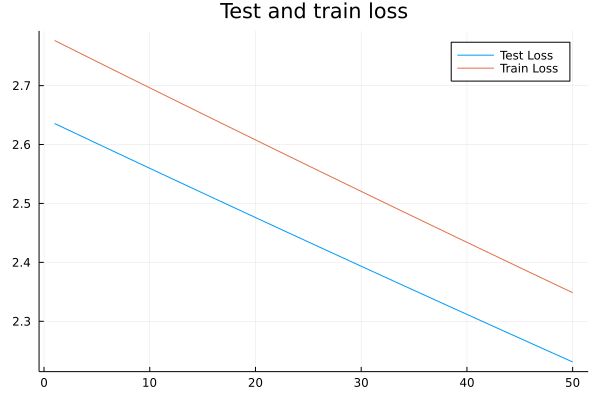

In [22]:
# Plot test and train loss
plot(1:args.epochs, arr_test_performance[:,1], labels= "Test Loss")
plot!(1:args.epochs, arr_train_performance[:,1], labels= "Train Loss")
title!("Test and train loss")

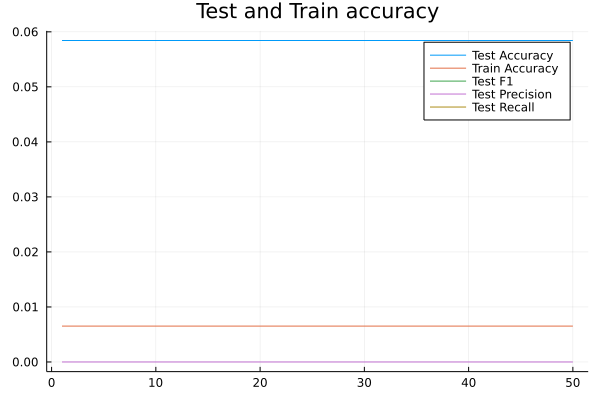

In [23]:
# Plot test and train accuracy, precision, recall, f1-score
plot(1:args.epochs, arr_test_performance[:,2], labels= "Test Accuracy")
plot!(1:args.epochs, arr_train_performance[:,2], labels= "Train Accuracy")
plot!(1:args.epochs, arr_test_performance[:,3], labels= "Test F1")
plot!(1:args.epochs, arr_test_performance[:,4], labels= "Test Precision")
plot!(1:args.epochs, arr_test_performance[:,5], labels= "Test Recall")
title!("Test and Train accuracy")

# Loss and accuracy analysis

Compute the epochs when loss is minimized and accuracy is maximized

In [24]:
# minimum test_loss
minimum(arr_test_performance[:,1])

2.2309682369232178

In [25]:
# epochs when minimum test_loss occurs
argmin(arr_test_performance[:,1])

50

In [26]:
# maximum test_accuracy
maximum(arr_test_performance[:,2])

0.05842018650575974

In [27]:
# epochs when maximum test_accuracy occurs
argmax(arr_test_performance[:,2]) 

1